In [1]:
#using mdels.py to create a cnn or regression
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# one example conv layer has been provided for you
from model import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.4)
)


In [11]:
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, utils
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])
assert(data_transform is not None), 'Define a data_transform'

In [12]:
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [13]:
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [14]:
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [15]:
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [16]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [17]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [18]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

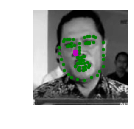

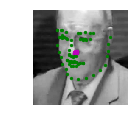

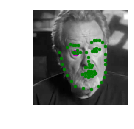

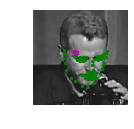

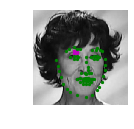

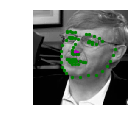

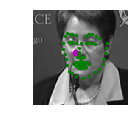

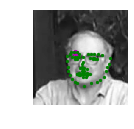

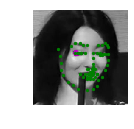

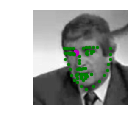

In [19]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [22]:
#learning area
import torch.optim as optim

#loss criteria to evaluated upon
criterion = nn.L1Loss()

#below optimizer takes care of the backward propagation and all
optimizer = optim.Adam(net.parameters(), lr = 0.001)


In [27]:
def train_net(n_epochs):
    net.train()
    for epoch in range(n_epochs):
        running_loss=0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0),-1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [29]:
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0034170123636722565
Epoch: 1, Batch: 20, Avg. Loss: 0.0037349646389484405
Epoch: 1, Batch: 30, Avg. Loss: 0.003603978604078293
Epoch: 1, Batch: 40, Avg. Loss: 0.0032543024122714996
Epoch: 1, Batch: 50, Avg. Loss: 0.0033736436665058136
Epoch: 1, Batch: 60, Avg. Loss: 0.003801181137561798
Epoch: 1, Batch: 70, Avg. Loss: 0.0032621550559997557
Epoch: 1, Batch: 80, Avg. Loss: 0.0033148575127124784
Epoch: 1, Batch: 90, Avg. Loss: 0.0035781566202640535
Epoch: 1, Batch: 100, Avg. Loss: 0.0034455121755599975
Epoch: 1, Batch: 110, Avg. Loss: 0.0035510846972465517
Epoch: 1, Batch: 120, Avg. Loss: 0.0036764044165611266
Epoch: 1, Batch: 130, Avg. Loss: 0.0037221422791481017
Epoch: 1, Batch: 140, Avg. Loss: 0.004041937738656997
Epoch: 1, Batch: 150, Avg. Loss: 0.0037424681782722473
Epoch: 1, Batch: 160, Avg. Loss: 0.0037473369240760804
Epoch: 1, Batch: 170, Avg. Loss: 0.003220729321241379
Epoch: 1, Batch: 180, Avg. Loss: 0.0032923389375209807
Epoch: 1, Batch: 190, A